# Binay VQE

This notebook formulates **asset selection** as a QUBO and solves it with a **Variational Quantum Eigensolver**.

### Problem

- Decision: $x_i ∈ \{0,1\}$ select asset $i$.
- Objective (mean–variance with cardinality):

  $\min_{x ∈ \{0,1\}^n}\; λ\, x^\top Σ x \;-\; μ^\top x \;+\; α\,(\mathbf{1}^\top x - K)^2$
  
  where $μ$ is expected returns, $Σ$ covariance, $K$ desired count, $λ$ risk aversion, $α$ penalty.

### Ising mapping

- Use $x_i=\tfrac{1-Z_i}{2}$. Expand to:
  
  $H = c + Σ_i h_i Z_i + Σ_{i<j} J_{ij} Z_i Z_j$

  with coefficients from the expanded QUBO. VQE minimizes $⟨ H ⟩$.

### Ansatz

- Hardware-efficient $R_Y$ layers with $C_Z$ ring entanglement and depth $d$.  
- Parameters $θ ∈ \mathbb{R}^{d × n}$.

### Optimization

- Cost: $E(θ) = ⟨H⟩$.  
- Optimizer: Adam with autograd and analytic gradients (parameter-shift).  
- Device: `default.qubit`, `shots=None` for exact expectations during training.

### Outputs

- **Convergence curve**: energy vs iteration.  
- **Inclusion probabilities**: $p_i = \tfrac{1-⟨Z_i⟩}{2}$.  
- **Sampled bitstrings**: histogram in Dirac notation $|b_1 … b_n⟩$.  
- **Candidate portfolios**: rounded vector, top-K projection, and sample-mode, with objective values.

### Validation

- Check $Σ_i x_i$ vs $K$ and increase $α$ if violated.  
- Compare to **brute-force** (for small $n$) or a **classical QUBO solver** for ground truth.

### Reproducibility

- Fix seeds for parameters and sampling.  
- Record $(λ, α, K, d, \text{steps})$ with results.

### Notes

- Larger $d$ and entanglers can improve expressivity but slow optimization.  
- For deployment, use finite `shots` and re-evaluate energies to estimate sampling variance.

In [13]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pennylane import draw_mpl

np.random.seed(0)

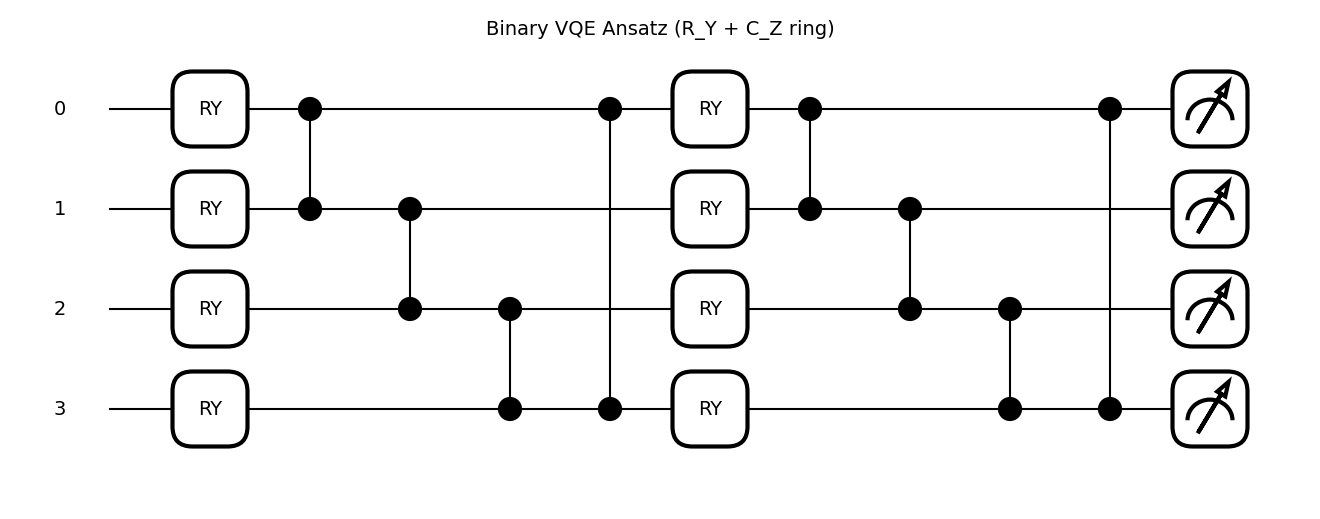

In [14]:
# Expected returns
mu = np.array([0.10, 0.20, 0.15, 0.12], requires_grad=False)

# Covariance matrix
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
], requires_grad=False)

n = len(mu)
lam = 1.0    # Risk aversion for selection
K = 2        # Select exactly K assets
alpha = 2.0  # Penalty strength

# Build Ising Hamiltonian for QUBO
def build_ising(mu, Sigma, lam, alpha, K):
    # f(x) = lam xᵀΣx − μᵀx + α(∑x − K)²
    # Expand into linear L_i and pairwise Q_ij terms over x∈{0,1}
    L = lam * np.diag(Sigma) - mu + alpha * (1 - 2*K)
    Q = 2 * lam * (Sigma - np.diag(np.diag(Sigma))) + 2 * alpha * (np.ones((n, n)) - np.eye(n))

    # Map x_i = (1 − Z_i)/2 → H = c + ∑ h_i Z_i + ∑ J_ij Z_i Z_j
    const = float(alpha * K**2 + 0.5 * np.sum(L) + 0.25 * np.sum(np.triu(Q,1)))
    h = -0.5 * L - 0.25 * np.sum(Q, axis=1)
    J = 0.25 * np.triu(Q, 1)  # Upper triangle only

    coeffs = [const]
    ops = [qml.Identity(0)]

    # Linear Z terms
    for i in range(n):
        if abs(h[i]) > 0:
            coeffs.append(float(h[i]))
            ops.append(qml.PauliZ(i))

    # Pairwise ZZ terms
    for i in range(n):
        for j in range(i+1, n):
            if abs(J[i, j]) > 0:
                coeffs.append(float(J[i, j]))
                ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)

H = build_ising(mu, Sigma, lam, alpha, K)

# Ansatz and cost
depth = 2
dev = qml.device("default.qubit", wires=n, shots=None)

def ansatz(params):
    # Hardware-efficient layers: R_Y + C_Z ring
    for d in range(depth):
        for i in range(n):
            qml.RY(params[d, i], wires=i)
        for i in range(n-1):
            qml.CZ(wires=[i, i+1])
        if n > 2:
            qml.CZ(wires=[n-1, 0])

@qml.qnode(dev, interface="autograd")
def energy(params):
    ansatz(params)
    return qml.expval(H)

# Circuit preview QNode
@qml.qnode(dev, interface="autograd")
def circuit_preview(p):
    ansatz(p)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

# Use a simple pattern of angles just for drawing
demo_params = np.tile(np.linspace(0, np.pi/2, n), (depth, 1))
fig, ax = draw_mpl(circuit_preview)(demo_params)
fig.suptitle("Binary VQE Ansatz (R_Y + C_Z ring)", fontsize=14)
plt.savefig("images/Binary_VQE_Circuit.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
# Optimize
params = np.array(np.random.uniform(0, np.pi, size=(depth, n)), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.3)
steps = 75
history = []

for t in range(steps):
    params, e = opt.step_and_cost(energy, params)
    if (t+1) % 5 == 0:
        history.append(float(e))
        print(f"step {t+1:03d}  energy={float(e):.6f}")

step 005  energy=0.570188
step 010  energy=0.163093
step 015  energy=-0.136216
step 020  energy=-0.060851
step 025  energy=-0.211303
step 030  energy=-0.203377
step 035  energy=-0.227576
step 040  energy=-0.233759
step 045  energy=-0.246321
step 050  energy=-0.250047
step 055  energy=-0.250925
step 060  energy=-0.252970
step 065  energy=-0.253197
step 070  energy=-0.253669
step 075  energy=-0.253833


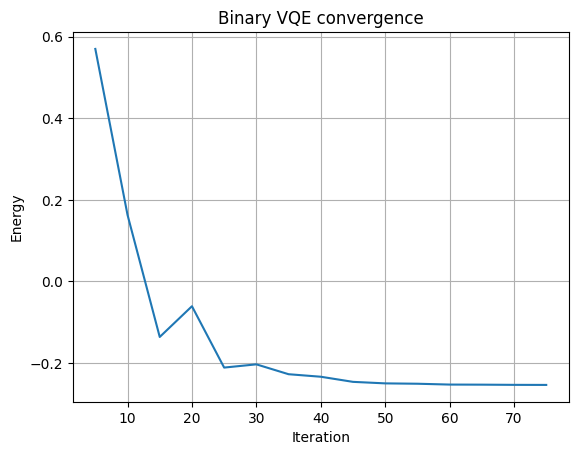

In [16]:
# Convergence plot
plt.figure()
plt.plot(range(5, steps+1, 5), history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("Binary VQE convergence")
plt.grid(True)
plt.savefig("images/Binary_VQE_Convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
# Inspect expected bits and sample a binary portfolio
@qml.qnode(dev, interface="autograd", diff_method="parameter-shift")
def exp_Z(params):
    ansatz(params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n)]

z = np.stack(exp_Z(params))
x_expect = (1 - z) * 0.5                 # in [0,1]
x_round = (x_expect >= 0.5).astype(int)  # naive rounding

print("Expected x:", x_expect.round(3))
print("Rounded x :", x_round.tolist(), " sum=", int(x_round.sum()))

Expected x: [0.023 1.    0.    0.977]
Rounded x : [0, 1, 0, 1]  sum= 2


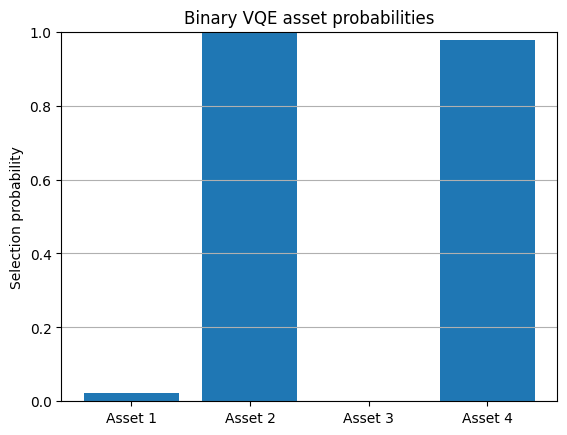

In [18]:
# Bar plot
x_probs = x_expect  # (1−⟨Z⟩)/2 values already in [0,1]
plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n)], x_probs)
plt.ylabel("Selection probability")
plt.ylim(0, 1)
plt.title("Binary VQE asset probabilities")
plt.grid(axis="y")
plt.savefig("images/Binary_VQE_Probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
# Project to exact K by taking top-K expectations
topK = np.argsort(-x_expect)[:K]
x_topk = np.zeros(n, dtype=int); x_topk[topK] = 1
print("Top-K x    :", x_topk.tolist(), " sum=", int(x_topk.sum()))

# Sample bitstrings to get a concrete solution
shots_sampler = qml.device("default.qubit", wires=n, shots=2000)

@qml.qnode(shots_sampler)
def sample_bits(p):
    ansatz(p)
    return qml.sample(wires=range(n))

samples = sample_bits(params)

# Convert ±1 Z basis to {0,1} via computational basis measurement:
# qml.sample returns bitstrings already in {0,1}; aggregate modes:
import numpy as _np
rows = _np.array(samples)
# majority vote per qubit
x_mode = (rows.mean(axis=0) >= 0.5).astype(int)
print("Sample-mode x:", x_mode.tolist(), " sum=", int(x_mode.sum()))

# Simple report
def objective_value(x):
    x = _np.array(x, dtype=float)
    return float(lam * x @ Sigma @ x - mu @ x + alpha * (x.sum() - K)**2)

print("Objective(round):", objective_value(x_round))
print("Objective(topK)  :", objective_value(x_topk))
print("Objective(mode)  :", objective_value(x_mode))

Top-K x    : [0, 1, 0, 1]  sum= 2
Sample-mode x: [0, 1, 0, 1]  sum= 2
Objective(round): -0.254
Objective(topK)  : -0.254
Objective(mode)  : -0.254


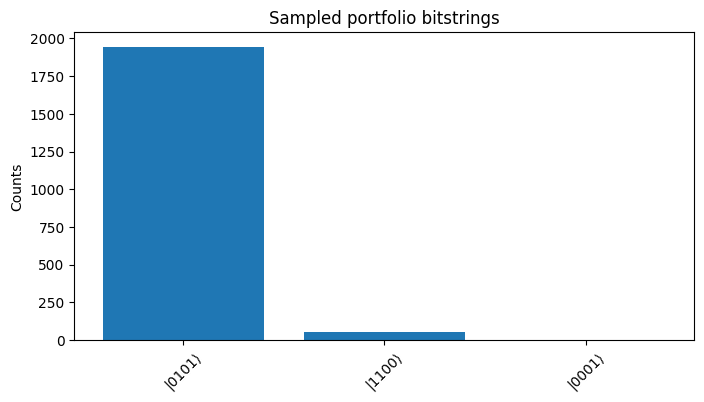

In [20]:
# Histogram of sampled binary strings
counts = Counter(tuple(row) for row in rows)
bitstrings = [''.join(map(str, bs)) for bs in counts.keys()]
frequencies = [counts[bs] for bs in counts.keys()]

# Convert to Dirac notation
labels = [f"|{b}⟩" for b in bitstrings]

plt.figure(figsize=(8,4))
plt.bar(labels, frequencies)
plt.xticks(rotation=45)
plt.ylabel("Counts")
plt.title("Sampled portfolio bitstrings")
plt.savefig("images/Binary_VQE_Portfolio_Bitstrings.png", dpi=300, bbox_inches="tight")
plt.show()